# Import

In [2]:
#Basic
import os
import requests
import pandas as pd
import geopandas as gpd
from io import StringIO
from shapely.geometry import Point, Polygon

#QGIS
from qgis.core import QgsApplication, QgsVectorLayer, QgsProcessingFeedback
from processing.core.Processing import Processing
import processing

# Data

Prepare function for API

In [3]:
#---------------------------------Air-Pollution-------------------------------

#----------------------------------Today data---------------------------------
# url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude=13.75&longitude=100.50&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone&domains=cams_global&timezone=Asia%2FBangkok"

#---------------------------With (start - end) Date---------------------------
# url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude=13.75&longitude=100.50&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone&domains=cams_global&timezone=Asia%2FBangkok&start_date=2023-01-01&end_date=2023-04-30"

def getAir(latitude, longitude, start, end):
  url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={latitude}&longitude={longitude}&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone&timezone=Asia%2FBangkok&start_date={start}&end_date={end}"
  # url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude=13.75&longitude=100.50&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone&timezone=Asia%2FBangkok&past_days=2"
  payload={}
  files={}
  headers = {"accept": "application/json"}

  response = requests.request("GET", url, headers=headers, data=payload, files=files)

  data = response.json()
  return data

In [4]:
#----------------------------------Hot-Spot-----------------------------------
def getHot():
  NASA_KEY = f"509bed55d292c9f1f37970d7bb5f4279"
  day_range = 7
  url = f'https://firms.modaps.eosdis.nasa.gov/api/country/csv/{NASA_KEY}/MODIS_NRT/THA/{day_range}'
  headers = {"accept": "application/json"}
  response = requests.get(url, headers=headers)
  return response.text
# test = pd.read_csv(StringIO(getHot()))
# test

Get Data from selected Province


In [5]:
def get_prov(selected_prov):
  province = selected_prov
  lati = 0
  longi = 0
  gp = pd.read_csv('data/Th_Province.csv')
  gp.loc[0,'province']
  for i in range(len(gp)):
    if gp.loc[i,'province'] == province:
      lati = gp.loc[i,'latitude']
      longi = gp.loc[i,'longitude']
      break
  return province,lati,longi

In [6]:
selected,latitude,longitude = get_prov('กรุงเทพมหานคร')

In [7]:
print(f'Province={selected} latitude={latitude} longitude={longitude}')
today = pd.Timestamp.today().strftime("%Y-%m-%d")
start_date = '2023-05-17'
end_date = '2023-05-17'
data = getAir(latitude,longitude,start_date,end_date)
# data

Province=กรุงเทพมหานคร latitude=13.72917 longitude=100.52389


Data Exploration

In [12]:
data['hourly']
df = pd.DataFrame(data['hourly'])
df_nodate = df.fillna(0).drop('time', axis=1)
df_nodate
# testAir = df.iloc[:25,1:]
# testAir

13.599998

In [15]:
def get_prov_data(dataframe,province,lat,long):
  new_df = pd.DataFrame(columns=['date','pm10','pm2_5','carbon_monoxide','nitrogen_dioxide','sulphur_dioxide','ozone'])
  df_nodate = dataframe.fillna(0).drop('time', axis=1)
  for i in range(int(len(df_nodate)/24)):
    d_range = 24*(i+1)
    time = str(dataframe.loc[d_range-1,'time']).split('T')[0]
    new_df = pd.concat([new_df,df_nodate.iloc[d_range-24:d_range,0:].mean().to_frame().T]).fillna(time)
  new_df.reset_index()
  prov_data = pd.concat([pd.DataFrame({'province':[province],'latitude':[lat],'longitude':[long]}),new_df],axis=1)
  return prov_data

In [16]:
th_province = pd.read_csv('data/Th_Province.csv')
column = ['province','latitude','longitude','date','pm10','pm2_5','carbon_monoxide','nitrogen_dioxide','sulphur_dioxide','ozone']
test = pd.DataFrame(columns=column)
for i in range(len(th_province)):
  province = th_province.loc[i,'province']
  latitude = th_province.loc[i,'latitude']
  longitude = th_province.loc[i,'longitude']
  #---------------------------Get_Air---------------------------#
  today = pd.Timestamp.today().strftime("%Y-%m-%d")
  start_date = '2023-05-17'
  end_date = '2023-05-17'
  air_data = getAir(latitude,longitude,start_date,end_date)
  df = pd.DataFrame(air_data['hourly'])
  temp = get_prov_data(df,province,latitude,longitude)
  # print(temp)
  test = pd.concat([test,temp])
#   location = pd.DataFrame({'latitude':[latitude],'longitude':[longitude]})
#   test = pd.concat([test,location],axis=1)
test

,province,latitude,longitude,date,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone
0,กรุงเทพมหานคร,13.72917,100.52389,2023-05-17,66.358333,43.866667,998.750000,31.704167,28.512500,189.791667
0,สมุทรปราการ,13.59556,100.60722,2023-05-17,75.025000,50.012500,1162.708333,45.762500,25.325000,189.833333
0,อุดรธานี,17.53917,102.78444,2023-05-17,25.850000,16.683333,269.541667,3.100000,0.641667,69.958333
0,นนทบุรี,13.85083,100.52222,2023-05-17,59.283333,39.325000,1261.625000,59.087500,13.562500,79.875000
0,ชลบุรี,13.36222,100.98333,2023-05-17,38.729167,24.637500,372.083333,9.437500,9.550000,144.583333
...,...,...,...,...,...,...,...,...,...,...
0,แม่ฮ่องสอน,19.30111,97.97000,2023-05-17,24.070833,15.645833,205.166667,1.258333,0.670833,77.666667
0,อุทัยธานี,15.29990,99.45620,2023-05-17,17.841667,11.450000,150.958333,0.533333,0.195833,50.500000
0,ปราจีนบุรี,14.05667,101.37389,2023-05-17,70.750000,47.341667,1002.916667,26.112500,13.125000,149.083333
0,นครนายก,14.12240,101.07120,2023-05-17,70.750000,47.341667,1002.916667,26.112500,13.125000,149.083333


Geometry list

In [17]:
geometry = [Point(xy) for xy in zip(test["longitude"],test["latitude"])]
geometry

[<POINT (100.524 13.729)>,
 <POINT (100.607 13.596)>,
 <POINT (102.784 17.539)>,
 <POINT (100.522 13.851)>,
 <POINT (100.983 13.362)>,
 <POINT (102.1 14.975)>,
 <POINT (98.961 18.79)>,
 <POINT (99.331 9.14)>,
 <POINT (100.037 13.816)>,
 <POINT (102.829 16.439)>,
 <POINT (104.859 15.228)>,
 <POINT (99.963 8.436)>,
 <POINT (102.255 13.791)>,
 <POINT (100.135 15.713)>,
 <POINT (100.264 16.816)>,
 <POINT (100.597 7.206)>,
 <POINT (100.569 14.354)>,
 <POINT (99.828 19.909)>,
 <POINT (101.283 6.542)>,
 <POINT (104.146 17.156)>,
 <POINT (98.392 7.88)>,
 <POINT (100.911 14.529)>,
 <POINT (99.61 7.558)>,
 <POINT (99.531 14.019)>,
 <POINT (102.738 17.874)>,
 <POINT (100.278 13.549)>,
 <POINT (99.522 16.481)>,
 <POINT (102.031 15.806)>,
 <POINT (100.096 17.623)>,
 <POINT (99.513 18.286)>,
 <POINT (100.627 14.8)>,
 <POINT (99.18 10.494)>,
 <POINT (103.509 16.434)>,
 <POINT (101.279 12.674)>,
 <POINT (103.301 16.177)>,
 <POINT (101.155 16.424)>,
 <POINT (101.07 13.69)>,
 <POINT (101.815 6.426)>,
 <

In [19]:
air_poll = gpd.GeoDataFrame(test,geometry=geometry)
# air_geo.sort_values(by='lastUpdated',ascending=False)
air_poll

,province,latitude,longitude,date,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,geometry
0,กรุงเทพมหานคร,13.72917,100.52389,2023-05-17,66.358333,43.866667,998.750000,31.704167,28.512500,189.791667,POINT (100.52389 13.72917)
0,สมุทรปราการ,13.59556,100.60722,2023-05-17,75.025000,50.012500,1162.708333,45.762500,25.325000,189.833333,POINT (100.60722 13.59556)
0,อุดรธานี,17.53917,102.78444,2023-05-17,25.850000,16.683333,269.541667,3.100000,0.641667,69.958333,POINT (102.78444 17.53917)
0,นนทบุรี,13.85083,100.52222,2023-05-17,59.283333,39.325000,1261.625000,59.087500,13.562500,79.875000,POINT (100.52222 13.85083)
0,ชลบุรี,13.36222,100.98333,2023-05-17,38.729167,24.637500,372.083333,9.437500,9.550000,144.583333,POINT (100.98333 13.36222)
...,...,...,...,...,...,...,...,...,...,...,...
0,แม่ฮ่องสอน,19.30111,97.97000,2023-05-17,24.070833,15.645833,205.166667,1.258333,0.670833,77.666667,POINT (97.97000 19.30111)
0,อุทัยธานี,15.29990,99.45620,2023-05-17,17.841667,11.450000,150.958333,0.533333,0.195833,50.500000,POINT (99.45620 15.29990)
0,ปราจีนบุรี,14.05667,101.37389,2023-05-17,70.750000,47.341667,1002.916667,26.112500,13.125000,149.083333,POINT (101.37389 14.05667)
0,นครนายก,14.12240,101.07120,2023-05-17,70.750000,47.341667,1002.916667,26.112500,13.125000,149.083333,POINT (101.07120 14.12240)


Export GeoJson

In [20]:
os.makedirs('sample_data', exist_ok=True)  
air_poll.to_json() 
air_poll.to_file('sample_data/air_pollution.geojson', driver="GeoJSON")

# PyQGIS

Initailize PyQGIS

In [21]:
Processing.initialize()

In [22]:
for alg in QgsApplication.processingRegistry().algorithms():
    if "native:" in alg.id():
        print(alg.id(), "--->", alg.displayName())

native:addautoincrementalfield ---> Add autoincremental field
native:addfieldtoattributestable ---> Add field to attributes table
native:adduniquevalueindexfield ---> Add unique value index field
native:addxyfields ---> Add X/Y fields to layer
native:affinetransform ---> Affine transform
native:aggregate ---> Aggregate
native:angletonearest ---> Align points to features
native:antimeridiansplit ---> Geodesic line split at antimeridian
native:arrayoffsetlines ---> Array of offset (parallel) lines
native:arraytranslatedfeatures ---> Array of translated features
native:aspect ---> Aspect
native:assignprojection ---> Assign projection
native:atlaslayouttoimage ---> Export atlas layout as image
native:atlaslayouttomultiplepdf ---> Export atlas layout as PDF (multiple files)
native:atlaslayouttopdf ---> Export atlas layout as PDF (single file)
native:batchnominatimgeocoder ---> Batch Nominatim geocoder
native:bookmarkstolayer ---> Convert spatial bookmarks to layer
native:boundary ---> Bound

In [23]:
processing.algorithmHelp("native:extractvertices")

Extract vertices (native:extractvertices)

This algorithm takes a line or polygon layer and generates a point layer with points representing the vertices in the input lines or polygons. The attributes associated to each point are the same ones associated to the line or polygon that the point belongs to.

Additional fields are added to the point indicating the vertex index (beginning at 0), the vertex’s part and its index within the part (as well as its ring for polygons), distance along original geometry and bisector angle of vertex for original geometry.


----------------
Input parameters
----------------

INPUT: Input layer

	Parameter type:	QgsProcessingParameterFeatureSource

	Accepted data types:
		- str: layer ID
		- str: layer name
		- str: layer source
		- QgsProcessingFeatureSourceDefinition
		- QgsProperty
		- QgsVectorLayer

OUTPUT: Vertices

	Parameter type:	QgsProcessingParameterFeatureSink

	Accepted data types:
		- str: destination vector file, e.g. 'd:/test.shp'
		- st

Get Input & Generate Output

In [25]:
input_vector = QgsVectorLayer("sample_data/air_pollution.geojson")
output_filename = "output.geojson"
params = {
    'INPUT': input_vector,
    'OUTPUT': output_filename
}
feedback = QgsProcessingFeedback()

processing.run("native:extractvertices", params, feedback=feedback)

{'OUTPUT': 'output.geojson'}

Plot

<Axes: >

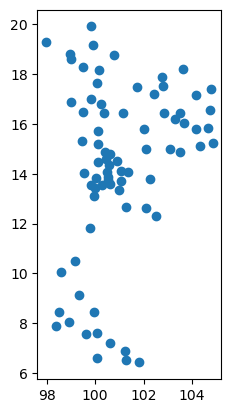

In [26]:
gdf = gpd.read_file(output_filename)
gdf.plot()

In [27]:
gdf.explore()